# Подготовка обучающего датасета

## Импорт модулей

In [1]:
import os
from objects import Field, Sample
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from dataset import PlantsDataset
from metrics_and_loss_fn import iou_pytorch
from model import UNet, predict
import matplotlib.pyplot as plt
from trainer import Trainer
import cv2
from torch.utils.data import DataLoader
from utils import (
                load_image, seed_everything,
                make_logical_masks_and_bboxes,
                draw_seg_masks,  draw_bboxes,
                norm_denoise, augment_data,
                SUPPORTED_IMAGE_FORMATS
                  )

import numpy as np
import seaborn as sns
from scipy import stats
import gc
import shutil

Подключим Google Drive для удобного взаимодействия с файлами. Позже можно будет открыть доступ к датасету всем членам команды.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Исследование фрагментов поля

Мы посмотрим, сколько пикселей белого цвета встречается на карте растительности фрагмента поля. Каждый фрагмент поля -  изображение 256 * 256 в формате RGB, маска -  изображение 256 * 256 в формате GRAYSCALE.

In [3]:
def save_train_data(samples: list[Sample], dir_dst: str, augment: bool = False):
  """
  Функция для сохранения изображений фрагментов поля
  и соответствующих им карт растительности.

  :params:
  samples - list[Sample] - список фграментов поля
  dir_dst - str          - путь к папке, куда сохранять обучающие данные
  augment - bool         - аугментировать ли изображения
  """

  if os.path.exists(dir_dst):
    shutil.rmtree(dir_dst)
  os.mkdir(dir_dst)

  path_to_masks_data = os.path.join(dir_dst, "mask")
  os.mkdir(path_to_masks_data)

  path_to_imgs_data = os.path.join(dir_dst, "img")
  os.mkdir(path_to_imgs_data)

  i = 0
  for sample in samples:
        augmented = augment_data(sample) if augment else [sample]
        for aug in augmented:
            filename = f'{i}.jpg'
            cv2.imwrite(f'{path_to_imgs_data}/{filename}', aug.image)
            cv2.imwrite(f'{path_to_masks_data}/{filename}', aug.mask)
            i += 1
        gc.collect()
  return path_to_masks_data, path_to_imgs_data


In [4]:
sum_pixels_mean = []
sum_pixels_mode = []
sum_pixels_median = []

PATH_TO_IMGS = "/content/drive/MyDrive/plants_detection/img"
PATH_TO_MASKS = "/content/drive/MyDrive/plants_detection/mask"

imgs_names = os.listdir(PATH_TO_IMGS)
masks_names = os.listdir(PATH_TO_MASKS)

In [5]:
def prepare_field_data(filename: str) -> tuple:
    """
    Загружает фотографию и карту растительности для поля.

    :params:
    filename - str -  путь к фотографии поля

    :returns:
    (image, mask) - tuple - кортеж, который содержит
     считанные фотографии в формате np.ndarray или None
    """
    name, _, ext = filename.rpartition('.')
    mask_name = name + "_mask."
    path_to_img = os.path.join(PATH_TO_IMGS, filename)
    image = load_image(path_to_img)
    for ext_mask in SUPPORTED_IMAGE_FORMATS:
        # если изображение можно открыть по такому пути
        try:
            path_to_mask = os.path.join(PATH_TO_MASKS, mask_name + ext_mask)
            mask = load_image(path_to_mask)
            # то потом мы его преобразуем в GRAYSCALE
            if mask is not None:
                mask = cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY)
            break
        except Exception:
            continue
    else:
      raise ValueError("no mask name for this image.")
    return image, mask


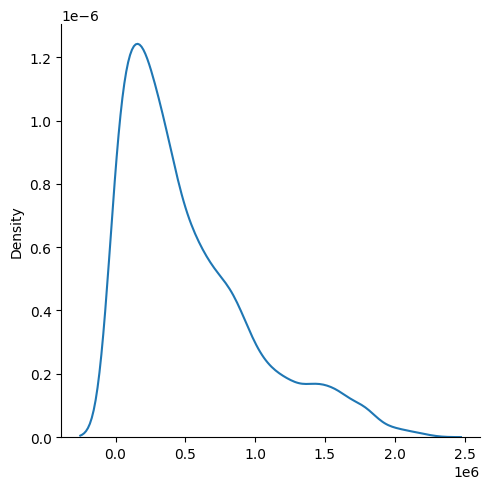

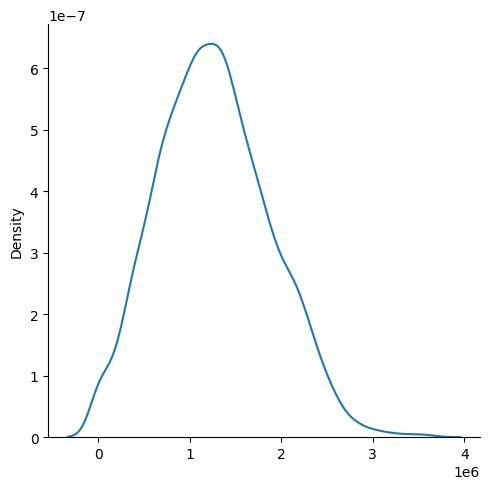

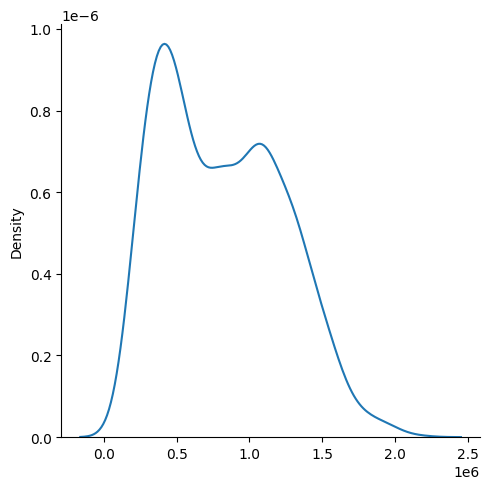

In [6]:
fields = []
for filename in imgs_names:
    image, mask = prepare_field_data(filename)

    if image is None or mask is None:
      continue

    field = Field(image, mask)

    sum_pixels = field.crop2sample()

    sum_pixels_mean.append(np.mean(sum_pixels))
    sum_pixels_mode.append(stats.mode(sum_pixels))
    sum_pixels_median.append(np.median(sum_pixels))

    # график распределения
    sns.displot(sum_pixels, kind='kde')

plt.show()

In [7]:
sum_pixels_mean # среднее

[518605.6669257676, 1265286.293237466, 814635.6608969315]

In [ ]:
sum_pixels_mode # мода

[ModeResult(mode=0.0, count=379),
 ModeResult(mode=0.0, count=72),
 ModeResult(mode=516185.0, count=16)]

In [ ]:
sum_pixels_median # медиана

[378702.0, 1237503.5, 772709.0]

Установим значение чуть меньше меньшей из медиан сумм пикселей для масок полей.

In [8]:
THRESHOLD = 378_000

In [9]:
fields = []
for filename in imgs_names:
    image, mask = prepare_field_data(filename)

    if image is None or mask is None:
      continue

    field = Field(image, mask)
    field.crop2sample(threshold=THRESHOLD)
    fields.append(field)

data = []
for field in fields:
  data += field.samples

In [ ]:
len(data)

8437

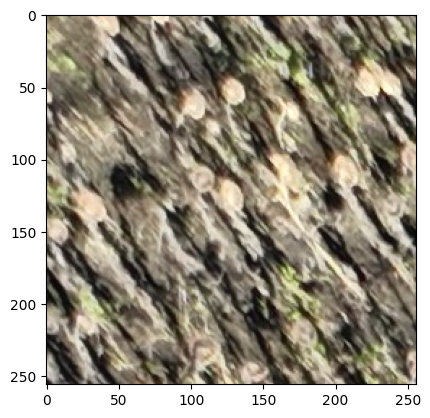

In [ ]:
plt.imshow(data[0].image)

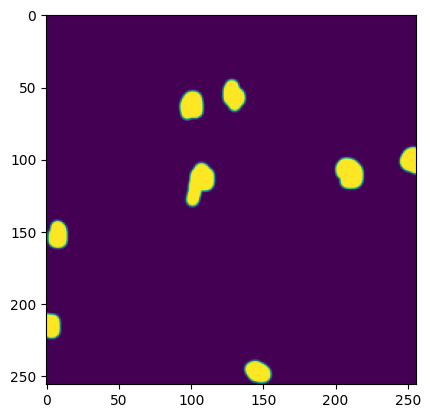

In [ ]:
plt.imshow(data[0].mask)

In [ ]:
data[0].image.shape

(256, 256, 3)

In [ ]:
len(data)

8437

In [ ]:
data[0].image.shape

(256, 256, 3)

Для теста, обработаем только первый фрагмент изображения из списка data.

In [ ]:
PATH_TO_DATASET = "/content/drive/MyDrive/plants_detection/dataset"

In [ ]:
TRAIN_MASK_DIR, TRAIN_IMG_DIR = save_train_data(data[:1], PATH_TO_DATASET,
                                                augment=True)
mask_paths, img_paths = map(os.listdir,
                          (TRAIN_MASK_DIR, TRAIN_IMG_DIR))

Проверим, что аугментации работают, выведя аугментации на картах растительности.

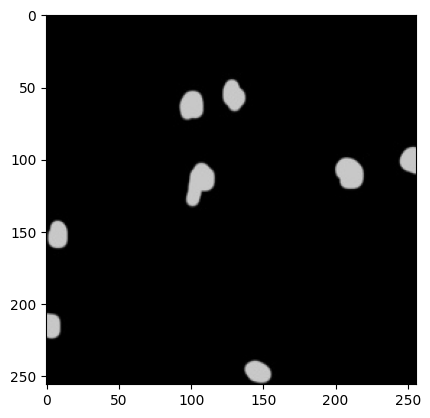

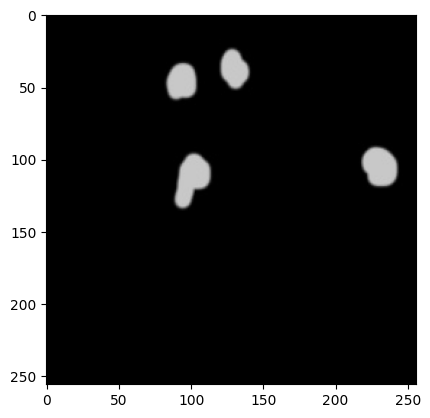

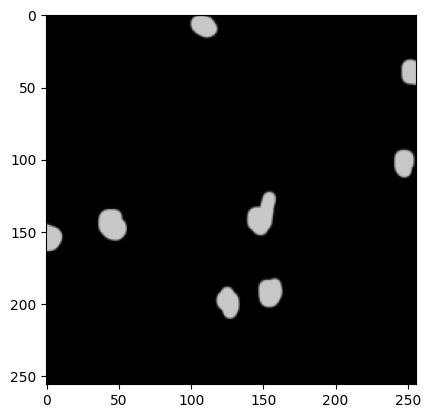

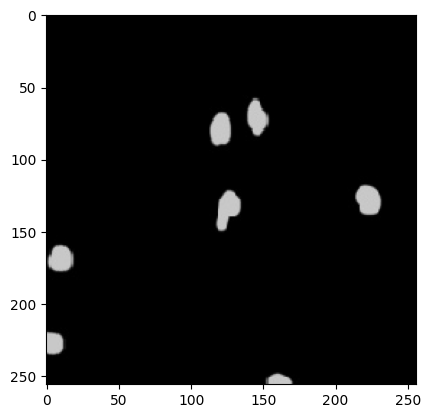

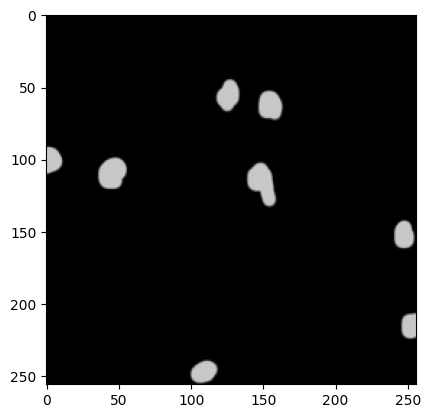

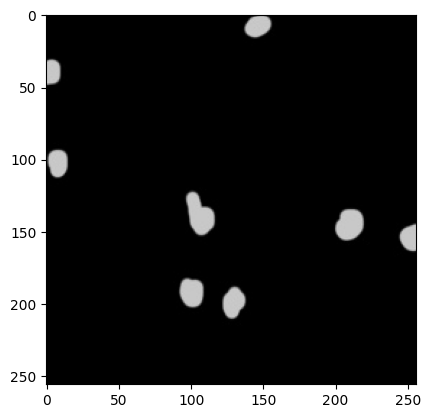

In [ ]:
for j in range(len(img_paths)):

    path = os.path.join(TRAIN_MASK_DIR, mask_paths[j])
    plt.imshow(load_image(path))
    plt.show()

В будущем обучим на аугментированных данных, а пока обойдемся без аугментаций.

In [ ]:
TRAIN_MASK_DIR, TRAIN_IMG_DIR = save_train_data(data, PATH_TO_DATASET,
                                                augment=False)